<a href="https://colab.research.google.com/github/wujj0326/COVID_Risk_Competition/blob/master/COVID_LSTM_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Packages

In [606]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from datetime import datetime
from keras.models import load_model
import random

RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
tf.compat.v1.set_random_seed(RANDOM_SEED)

Reference: https://medium.com/datadriveninvestor/covid19-time-series-forecasting-using-lstm-rnn-753a04944483

## Data Preparation

In [441]:
global_case = pd.read_csv('https://data.ca.gov/dataset/590188d5-8545-4c93-a9a0-e230f0db7290/resource/926fd08f-cc91-4828-af38-bd45de97f8c3/download/statewide_cases.csv')

In [442]:
global_case.head()

,county,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,date
0,Santa Clara,151.0,6.0,151,6,2020-03-18
1,Santa Clara,183.0,8.0,32,2,2020-03-19
2,Santa Clara,246.0,8.0,63,0,2020-03-20
3,Santa Clara,269.0,10.0,23,2,2020-03-21
4,Santa Clara,284.0,13.0,15,3,2020-03-22


In [443]:
la_cases = global_case[global_case['county']=='Los Angeles'].reset_index(drop=True)

In [444]:
la_cases['new_date'] = pd.to_datetime(la_cases['date'])

In [445]:
la_trunc = la_cases.loc[la_cases['date']>'2020-03-24',['totalcountconfirmed','totalcountdeaths','newcountconfirmed','newcountdeaths','new_date']]

In [446]:
la_trunc.head()

,totalcountconfirmed,totalcountdeaths,newcountconfirmed,newcountdeaths,new_date
7,725.0,10.0,92,-1,2020-03-25
8,1075.0,18.0,350,8,2020-03-26
9,1474.0,26.0,399,8,2020-03-27
10,1800.0,32.0,326,6,2020-03-28
11,2119.0,37.0,319,5,2020-03-29


In [447]:
la_daily = la_trunc.set_index('new_date')

In [448]:
la_daily.shape

(143, 4)

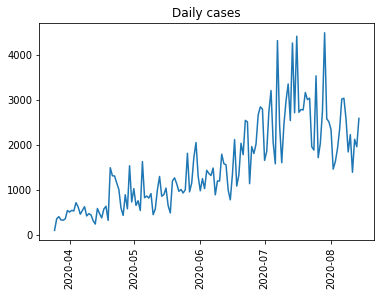

In [449]:
plt.plot(la_daily['newcountconfirmed'])
plt.title("Daily cases")
plt.xticks(rotation = 90)
plt.show()

In [450]:
la_ts_confirmed = la_daily.iloc[:,[0]]
la_ts_death = la_daily.iloc[:,[1]]

## Confirmed Model

### Preprocessing

In [451]:
len(la_ts_confirmed)

143

In [452]:
# predict 5 days afterwards
x = len(la_ts_confirmed)-5
x

138

In [453]:
train = la_ts_confirmed.iloc[:x]
test = la_ts_confirmed.iloc[x:]
train

,totalcountconfirmed
new_date,
2020-03-25,725.0
2020-03-26,1075.0
2020-03-27,1474.0
2020-03-28,1800.0
2020-03-29,2119.0
...,...
2020-08-05,198355.0
2020-08-06,201372.0
2020-08-07,204406.0


In [495]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
print(scaled_train[-5:])

[[0.94975611]
 [0.96425499]
 [0.97883557]
 [0.99116227]
 [1.        ]]


In [497]:
print(scaled_test)

[[1.01069275]
 [1.01735349]
 [1.02754644]
 [1.03694163]
 [1.04936925]]


In [456]:
# ?TimeseriesGenerator

# This class takes in a sequence of data-points gathered at
# equal intervals, along with time series parameters such as
# stride, length of history, etc., to produce batches for
# training/validation.

In [457]:
## how to decide num of inputs , 
n_input = 5  ## number of steps
n_features = 1 ## number of features you want to predict (for univariate time series n_features=1)
generator = TimeseriesGenerator(data = scaled_train, targets = scaled_train, length = n_input, batch_size=1)

In [458]:
len(generator)

133

we are taking 5 steps i.e taking 5 data points in account to predict 6th data point. So, The batches would be [feed=[t1,t2,t3,t4,t5],predict=t6].

Therefore, the [-6] data point would be the last one which contains all true data.

In [459]:
generator[-6]

(array([[[0.9385059 ],
         [0.94975611],
         [0.96425499],
         [0.97883557],
         [0.99116227]]]), array([[1.]]))

### Model Building

In [460]:
model = Sequential()
model.add(LSTM(150,activation="relu",input_shape=(n_input,n_features)))
model.add(Dropout(0.2))
model.add(Dense(75, activation='relu'))
model.add(Dense(units=1))
model.compile(optimizer="adam",loss="mse")

In [461]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 150)               91200     
_________________________________________________________________
dropout_13 (Dropout)         (None, 150)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 75)                11325     
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 76        
Total params: 102,601
Trainable params: 102,601
Non-trainable params: 0
_________________________________________________________________


In [462]:
validation_set = np.append(scaled_train[-1],scaled_test)
validation_set=validation_set.reshape(6,1)
validation_set

array([[1.        ],
       [1.01069275],
       [1.01735349],
       [1.02754644],
       [1.03694163],
       [1.04936925]])

In [463]:
validation_gen = TimeseriesGenerator(validation_set, validation_set, length=n_input, batch_size=1)

In [464]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=20,restore_best_weights=True)

In [465]:
model.fit_generator(generator, validation_data=validation_gen, epochs=100, callbacks=[early_stop], steps_per_epoch=10)

Epoch 1/100
10/10 [==============================] - 0s 23ms/step - loss: 0.1055 - val_loss: 0.7129
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0883 - val_loss: 0.3495
Epoch 3/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0442 - val_loss: 0.0482
Epoch 4/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0251 - val_loss: 0.0026
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0137 - val_loss: 0.0332
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 9.7341e-04
Epoch 7/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0014 - val_loss: 6.3175e-04
Epoch 8/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0039 - val_loss: 0.0010
Epoch 9/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 2.4592e-04
Epoch 10/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 2.6

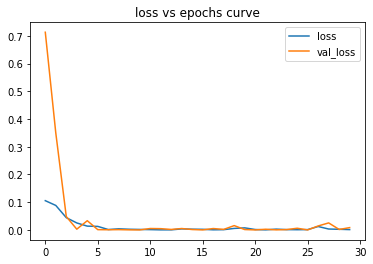

In [466]:
pd.DataFrame(model.history.history).plot(title="loss vs epochs curve")

### Forecasting

In [467]:
## holding predictions
test_prediction = []

##last n points from training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

In [469]:
## how far in future we can predict
for i in range(len(test)+7):
    current_pred = model.predict(current_batch)[0]
    test_prediction.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [470]:
### inverse scaled data
true_prediction = scaler.inverse_transform(test_prediction)
true_prediction[:,0]

array([210052.21809268, 212557.04453468, 214949.62534249, 217244.44702446,
       219499.48041975, 221859.04488742, 224445.87885797, 227057.36965954,
       229731.94126725, 232501.91546261, 235396.26526237, 238419.85257685])

In [471]:
time_series_array = test.index
for k in range(0,7):
    time_series_array = time_series_array.append(time_series_array[-1:] + pd.DateOffset(1))
time_series_array

DatetimeIndex(['2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13',
               '2020-08-14', '2020-08-15', '2020-08-16', '2020-08-17',
               '2020-08-18', '2020-08-19', '2020-08-20', '2020-08-21'],
              dtype='datetime64[ns]', name='new_date', freq=None)

In [651]:
df_forecast = pd.DataFrame(columns=["confirmed","confirmed_predicted"],index=time_series_array)
df_forecast.loc[:,"confirmed_predicted"] = true_prediction[:,0]
df_forecast.loc[:,"confirmed"] = test['totalcountconfirmed']

In [652]:
df_forecast

,confirmed,confirmed_predicted
new_date,,
2020-08-10,211035.0,210052.218093
2020-08-11,212421.0,212557.044535
2020-08-12,214542.0,214949.625342
2020-08-13,216497.0,217244.447024
2020-08-14,219083.0,219499.480420
2020-08-15,NaN,221859.044887
2020-08-16,NaN,224445.878858
2020-08-17,NaN,227057.369660
2020-08-18,NaN,229731.941267


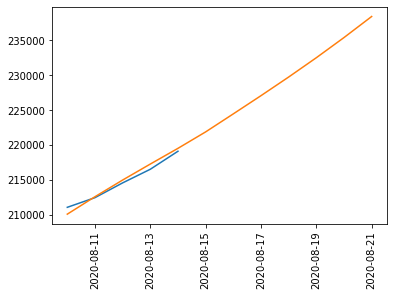

In [653]:
plt.plot(df_forecast)
plt.xticks(rotation = 90)
plt.show()

### Generate Predicted Confirmed Data

In [478]:
df_forecast['confirmed_predicted'] = round(df_forecast['confirmed_predicted'],0)

In [479]:
stdev = np.std(df_forecast['confirmed_predicted'])
interval = stdev*1.96

In [481]:
df_forecast['confirmed_high'] = round(df_forecast['confirmed_predicted']+interval,0)
df_forecast['confirmed_low'] = round(df_forecast['confirmed_predicted']-interval,0)
df_forecast

,confirmed,confirmed_predicted,confirmed_high,confirmed_low
new_date,,,,
2020-08-10,211035.0,210052.0,227296.0,192808.0
2020-08-11,212421.0,212557.0,229801.0,195313.0
2020-08-12,214542.0,214950.0,232194.0,197706.0
2020-08-13,216497.0,217244.0,234488.0,200000.0
2020-08-14,219083.0,219499.0,236743.0,202255.0
2020-08-15,NaN,221859.0,239103.0,204615.0
2020-08-16,NaN,224446.0,241690.0,207202.0
2020-08-17,NaN,227057.0,244301.0,209813.0
2020-08-18,NaN,229732.0,246976.0,212488.0


In [486]:
# cases_prediction = df_forecast.iloc[-7:,1:]

,confirmed_predicted,confirmed_high,confirmed_low
new_date,,,
2020-08-15,221859.0,239103.0,204615.0
2020-08-16,224446.0,241690.0,207202.0
2020-08-17,227057.0,244301.0,209813.0
2020-08-18,229732.0,246976.0,212488.0
2020-08-19,232502.0,249746.0,215258.0
2020-08-20,235396.0,252640.0,218152.0
2020-08-21,238420.0,255664.0,221176.0


## Death Model

### Preprocessing

In [490]:
# The length of train size
x

138

In [491]:
train_d = la_ts_death.iloc[:x]
test_d = la_ts_death.iloc[x:]
train_d

,totalcountdeaths
new_date,
2020-03-25,10.0
2020-03-26,18.0
2020-03-27,26.0
2020-03-28,32.0
2020-03-29,37.0
...,...
2020-08-05,4825.0
2020-08-06,4869.0
2020-08-07,4918.0


In [498]:
scaler_d = MinMaxScaler()
scaler_d.fit(train_d)
scaled_train = scaler_d.transform(train_d)
scaled_test = scaler_d.transform(test_d)
print(scaled_train[-5:])

[[0.96939803]
 [0.97825649]
 [0.9881216 ]
 [0.99798671]
 [1.        ]]


In [499]:
scaled_test

array([[1.00382525],
       [1.0161063 ],
       [1.0265754 ],
       [1.03905778],
       [1.04771492]])

In [500]:
## how to decide num of inputs , 
n_input = 5  ## number of steps
n_features = 1 ## number of features you want to predict (for univariate time series n_features=1)
generator = TimeseriesGenerator(data = scaled_train, targets = scaled_train, length = n_input, batch_size=1)

In [501]:
generator[-6]

(array([[[0.955909  ],
         [0.96939803],
         [0.97825649],
         [0.9881216 ],
         [0.99798671]]]), array([[1.]]))

### Model Building

In [640]:
model_t = Sequential()
model_t.add(LSTM(180,activation="relu",input_shape=(n_input,n_features)))
model_t.add(Dropout(0.3))
model_t.add(Dense(60, activation='relu'))
model_t.add(Dense(units=1))
model_t.compile(optimizer="adam",loss="mse")

In [641]:
validation_set = np.append(scaled_train[-1],scaled_test)
validation_set=validation_set.reshape(6,1)
validation_set

array([[1.        ],
       [1.00382525],
       [1.0161063 ],
       [1.0265754 ],
       [1.03905778],
       [1.04771492]])

In [642]:
validation_gen = TimeseriesGenerator(validation_set, validation_set, length=n_input, batch_size=1)

In [643]:
model_t.fit_generator(generator, validation_data=validation_gen, epochs=100, callbacks=[early_stop], steps_per_epoch=10)

Epoch 1/100
10/10 [==============================] - 0s 23ms/step - loss: 0.2879 - val_loss: 0.4671
Epoch 2/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0742 - val_loss: 0.0384
Epoch 3/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0238 - val_loss: 0.0191
Epoch 4/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0226 - val_loss: 0.0435
Epoch 5/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0207 - val_loss: 0.0530
Epoch 6/100
10/10 [==============================] - 0s 6ms/step - loss: 0.0042 - val_loss: 0.0076
Epoch 7/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0038 - val_loss: 0.0094
Epoch 8/100
10/10 [==============================] - 0s 7ms/step - loss: 0.0074 - val_loss: 0.0091
Epoch 9/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0129 - val_loss: 0.0126
Epoch 10/100
10/10 [==============================] - 0s 8ms/step - loss: 0.0076 - val_loss: 0.0029
Epoch 11

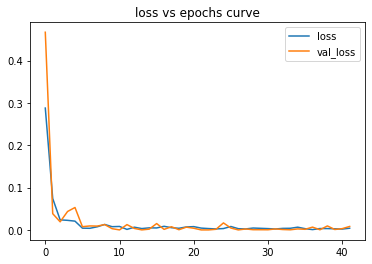

In [644]:
pd.DataFrame(model_t.history.history).plot(title="loss vs epochs curve")

### Forecasting

In [645]:
## holding predictions
test_pred_death = []

##last n points from training set
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape(1,n_input,n_features)

In [646]:
## how far in future we can predict
for i in range(len(test_d)+7):
    current_pred = model_t.predict(current_batch)[0]
    test_pred_death.append(current_pred)
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [647]:
### inverse scaled data
true_pred_death = scaler_d.inverse_transform(test_pred_death)
true_pred_death[:,0]

array([5043.66358256, 5091.73838401, 5140.76707876, 5190.32867479,
       5240.17626119, 5298.48809636, 5355.25629413, 5414.11760974,
       5475.1721102 , 5538.90414357, 5605.83950579, 5674.88752556])

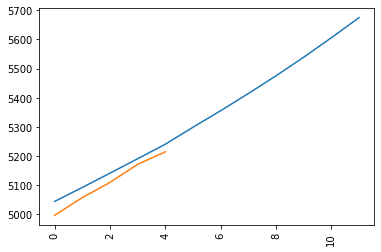

In [658]:
plt.plot(true_pred_death[:,0])
plt.plot(test_d['totalcountdeaths'].values)
plt.xticks(rotation = 90)
plt.show()

## Generate Predicted Data

In [661]:
df_forecast.loc[:,"death_predicted"] = true_pred_death[:,0]
df_forecast.loc[:,"death"] = test_d['totalcountdeaths']

In [662]:
df_forecast

,confirmed,confirmed_predicted,death_predicted,death
new_date,,,,
2020-08-10,211035.0,210052.218093,5043.663583,4996.0
2020-08-11,212421.0,212557.044535,5091.738384,5057.0
2020-08-12,214542.0,214949.625342,5140.767079,5109.0
2020-08-13,216497.0,217244.447024,5190.328675,5171.0
2020-08-14,219083.0,219499.480420,5240.176261,5214.0
2020-08-15,NaN,221859.044887,5298.488096,NaN
2020-08-16,NaN,224445.878858,5355.256294,NaN
2020-08-17,NaN,227057.369660,5414.117610,NaN
2020-08-18,NaN,229731.941267,5475.172110,NaN


In [663]:
df_forecast['confirmed_predicted'] = round(df_forecast['confirmed_predicted'],0)
df_forecast['death_predicted'] = round(df_forecast['death_predicted'],0)

In [664]:
stdev_c = np.std(df_forecast['confirmed_predicted'])
interval_c = stdev*1.96

In [668]:
stdev_d = np.std(df_forecast['death_predicted'])
interval_d = stdev_d*1.96

In [669]:
df_forecast['confirmed_high'] = round(df_forecast['confirmed_predicted'] + interval_c,0)
df_forecast['confirmed_low'] = round(df_forecast['confirmed_predicted'] - interval_c,0)
df_forecast['death_high'] = round(df_forecast['death_predicted'] + interval_d,0)
df_forecast['death_low'] = round(df_forecast['death_predicted'] - interval_d,0)
df_forecast

,confirmed,confirmed_predicted,death_predicted,death,confirmed_high,confirmed_low,death_high,death_low
new_date,,,,,,,,
2020-08-10,211035.0,210052.0,5044.0,4996.0,227296.0,192808.0,5432.0,4656.0
2020-08-11,212421.0,212557.0,5092.0,5057.0,229801.0,195313.0,5480.0,4704.0
2020-08-12,214542.0,214950.0,5141.0,5109.0,232194.0,197706.0,5529.0,4753.0
2020-08-13,216497.0,217244.0,5190.0,5171.0,234488.0,200000.0,5578.0,4802.0
2020-08-14,219083.0,219499.0,5240.0,5214.0,236743.0,202255.0,5628.0,4852.0
2020-08-15,NaN,221859.0,5298.0,NaN,239103.0,204615.0,5686.0,4910.0
2020-08-16,NaN,224446.0,5355.0,NaN,241690.0,207202.0,5743.0,4967.0
2020-08-17,NaN,227057.0,5414.0,NaN,244301.0,209813.0,5802.0,5026.0
2020-08-18,NaN,229732.0,5475.0,NaN,246976.0,212488.0,5863.0,5087.0


In [674]:
# extract the last 8 row because we would calculte the difference between the day and its previous day
# therefore, we would get the 7 days (one week) differences 
predicted_data = df_forecast.iloc[-8:,[1,4,5,2,6,7]]

In [675]:
predicted_data

,confirmed_predicted,confirmed_high,confirmed_low,death_predicted,death_high,death_low
new_date,,,,,,
2020-08-14,219499.0,236743.0,202255.0,5240.0,5628.0,4852.0
2020-08-15,221859.0,239103.0,204615.0,5298.0,5686.0,4910.0
2020-08-16,224446.0,241690.0,207202.0,5355.0,5743.0,4967.0
2020-08-17,227057.0,244301.0,209813.0,5414.0,5802.0,5026.0
2020-08-18,229732.0,246976.0,212488.0,5475.0,5863.0,5087.0
2020-08-19,232502.0,249746.0,215258.0,5539.0,5927.0,5151.0
2020-08-20,235396.0,252640.0,218152.0,5606.0,5994.0,5218.0
2020-08-21,238420.0,255664.0,221176.0,5675.0,6063.0,5287.0


In [676]:
predicted_data.to_csv('predicted_data.csv')